# Compare DSPS SED models with Fors2 Spectra


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- CC: kernel conda_jax0235_py310
- creation date : 2023-10-03
- update : 2023-10-03


From this mergin work on spectra and photometry can start

In [1]:
import h5py
import pandas as pd
import numpy as np
import os
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
import re
import matplotlib.gridspec as gridspec
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [2]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [3]:
from diffstar.defaults import DEFAULT_MAH_PARAMS
from diffstar.defaults import DEFAULT_MS_PARAMS
from diffstar.defaults import DEFAULT_Q_PARAMS

2023-11-10 09:19:08.884360: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-11-10 09:19:08.957623: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-11-10 09:19:08.962329: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-11-10 09:19:09.822907: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such fil

In [4]:
from diffstar import sfh_singlegal
from dsps.cosmology import age_at_z, DEFAULT_COSMOLOGY

In [5]:
from dsps import load_ssp_templates

In [6]:
from dsps import calc_rest_sed_sfh_table_lognormal_mdf
from dsps import calc_rest_sed_sfh_table_met_table

In [7]:
from dsps.dust.att_curves import  sbl18_k_lambda, RV_C00,_frac_transmission_from_k_lambda

In [8]:
import sys
sys.path.append("../../lib")

In [9]:
from fit_params_fors2 import U_FNU,U_FL,ConvertFlambda_to_Fnu,flux_norm,ordered_keys,Fors2DataAcess

In [10]:
lambda_red = 6231
lambda_width = 50
lambda_sel_min = lambda_red-lambda_width /2.
lambda_sel_max = lambda_red+lambda_width /2.

# Read Fors2 / Galex and Kids

In [11]:
input_file_h5  = '../../data/fors2sl/FORS2spectraGalexKidsPhotom.hdf5'

In [12]:
fors2 = Fors2DataAcess(input_file_h5)

In [13]:
list_of_keys = fors2.get_list_of_groupkeys()
list_of_attributes = fors2.get_list_subgroup_keys()

## Must sort spectra name

In [14]:
list_of_keys = np.array(list_of_keys)

In [15]:
list_of_keysnum = [ int(re.findall("SPEC(.*)",specname)[0]) for specname in  list_of_keys ]

In [16]:
sorted_indexes = np.argsort(list_of_keysnum)

In [17]:
list_of_keys = list_of_keys[sorted_indexes]

In [18]:
# fors2.getattribdata_fromgroup('SPEC102')

In [19]:
# fors2.getspectrum_fromgroup('SPEC102')

In [20]:
df_info = pd.DataFrame(columns=list_of_attributes)
all_df = []

In [21]:
for idx,key in enumerate(list_of_keys):
    attrs = fors2.getattribdata_fromgroup(key)
    spectr = fors2.getspectrum_fromgroup(key)
    df_info.loc[idx] = [*attrs.values()] # hope the order of attributes is kept
    df = pd.DataFrame({"wl":spectr["wl"],"fnu":spectr["fnu"]})
    all_df.append(df)
    

/pbs/throng/lsst/users/dagoret/desc/JAX2023/miniconda3/envs/conda_jax0325_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/pbs/throng/lsst/users/dagoret/desc/JAX2023/miniconda3/envs/conda_jax0325_py310/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
df_info.reset_index(drop=True, inplace=True) 

In [23]:
df_info = df_info[ordered_keys]

In [24]:
df_info

,name,num,ra,dec,redshift,Rmag,RT,RV,eRV,Nsp,...,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks,FLUX_RADIUS,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i
0,SPEC2,2,13.52997,-28.44776,0.34555,21.18,12.3,103665,40,1,...,179.816220,356.027740,290.613160,594.538760,694.397200,2.967994,0.072517,0.056505,0.039090,0.029048
1,SPEC3,3,13.52552,-28.42080,0.68660,21.45,11.6,210642,48,4,...,179.913452,352.837769,287.987885,588.559448,685.337463,3.020974,0.075065,0.058490,0.040463,0.030069
2,SPEC9,9,13.50219,-28.40641,0.29266,21.60,13.1,87798,58,1,...,185.288483,330.740845,268.486725,579.864075,606.197693,2.671784,0.074299,0.057893,0.040050,0.029762
3,SPEC13,13,13.49261,-28.38272,0.68870,23.14,0.0,206610,0,1,...,180.381531,323.638702,260.288177,NaN,NaN,2.192928,0.077572,0.060444,0.041815,0.031073
4,SPEC19,19,13.60758,-28.43452,0.48395,21.70,7.1,145185,104,1,...,123.689148,238.951889,225.177338,544.024658,507.931976,2.992076,0.075642,0.058940,0.040774,0.030300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,SPEC734,734,13.68083,-28.23290,0.23012,0.00,7.2,69036,71,1,...,98.486717,243.505157,196.822708,461.214691,495.400299,3.462931,0.073033,0.056906,0.039368,0.029254
546,SPEC735,735,13.69958,-28.23161,0.36169,19.28,8.2,108507,107,1,...,102.504509,254.145142,206.989441,479.774139,521.821655,3.587435,0.072326,0.056356,0.038987,0.028971
547,SPEC736,736,13.66431,-28.22849,0.55777,21.64,10.5,167331,31,1,...,108.492714,222.538773,185.683838,429.756744,456.459747,4.769248,0.074087,0.057728,0.039936,0.029677
548,SPEC737,737,13.62722,-28.22692,0.52001,21.40,10.2,156003,53,1,...,105.423523,216.082657,179.259644,419.079620,434.556122,2.864109,0.079347,0.061827,0.042772,0.031784


# Select good match with galex

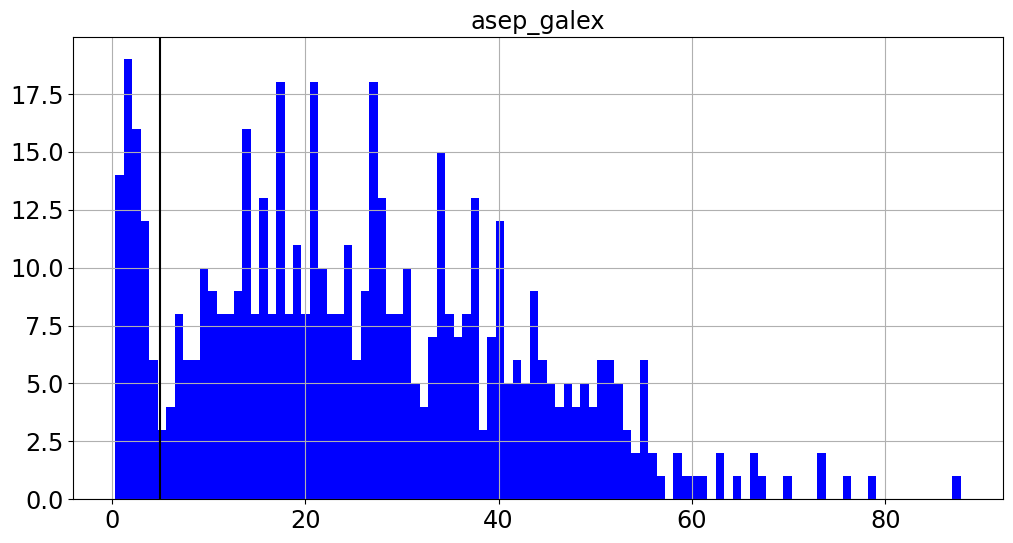

In [25]:
df_info.hist("asep_galex",bins=100,color="b")
plt.axvline(5,c="k")

array([[<Axes: title={'center': 'asep_kids'}>]], dtype=object)

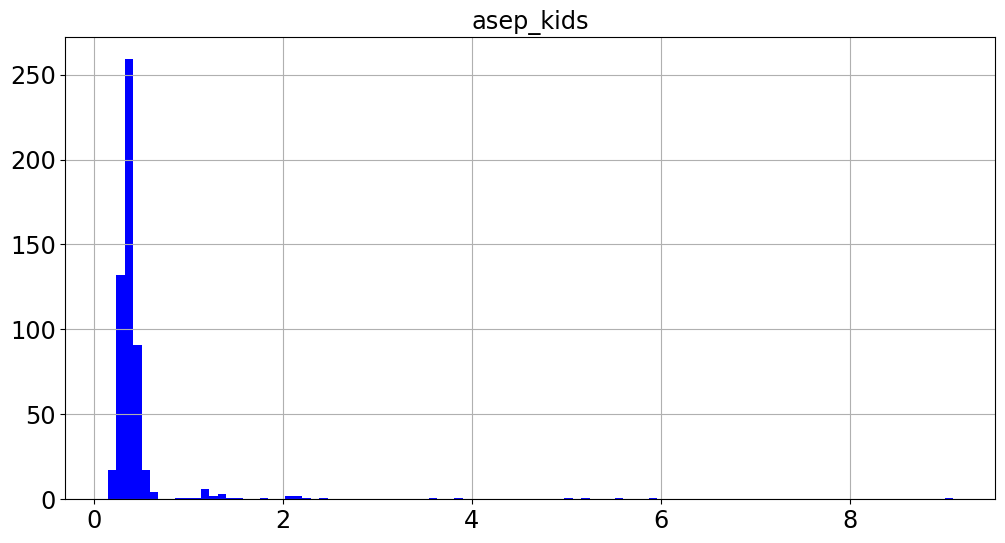

In [26]:
df_info.hist("asep_kids",bins=100,color='b')

## Select  Those spectra having GALEX

In [27]:
df = df_info[df_info["asep_galex"] <= 5]

In [28]:
df.index

Index([ 13,  38,  70,  98,  99, 113, 158, 159, 163, 171, 172, 182, 193, 205,
       210, 215, 228, 232, 241, 243, 244, 245, 253, 256, 257, 263, 275, 276,
       278, 285, 292, 312, 313, 316, 331, 345, 348, 382, 384, 386, 387, 395,
       409, 411, 413, 416, 425, 428, 431, 442, 458, 459, 461, 463, 469, 473,
       480, 483, 504, 511, 512, 528, 530, 533, 535, 536, 538, 543],
      dtype='int64')

## Remove NaN

- remove those row with no FUV

In [29]:
#df = df.dropna()

## Remove rows with Rmag = 0

In [30]:
#df = df[df["Rmag"] > 0]

# Plot Spectra

https://en.wikipedia.org/wiki/Photometric_system

In [31]:
lambda_FUV = 1528.
lambda_NUV = 2271.
lambda_U = 3650.
lambda_B = 4450.
lambda_G = 4640.
lambda_R = 5580.
lambda_I = 8060.
lambda_Z = 9000.
lambda_Y = 10200.
lambda_J = 12200.
lambda_H = 16300.
lambda_K = 21900.
lambda_L = 34500.

WL = [lambda_FUV, lambda_NUV, lambda_B, lambda_G, lambda_R ,lambda_I, lambda_Z, lambda_Y, lambda_J, lambda_H, lambda_K ]
FilterTag = ['FUV','NUV','B','G','R','I','Z','Y','J','H','Ks']

In [32]:
def PlotFilterTag(ax,fluxlist):
    goodfl = fluxlist[np.isfinite(fluxlist)]
    ymin = np.mean(goodfl)
    dy=ymin/5
   
    for idx,flux in enumerate(fluxlist):
        if np.isfinite(flux):
            #ax.text(WL[idx],flux, FilterTag[idx],fontsize=10,ha='center', va='bottom')
                     
            fl = flux - dy
            if fl <0:
                fl += 2*dy
            ax.text(WL[idx],fl, FilterTag[idx],fontsize=12,color="g",weight='bold',ha='center', va='bottom')
            

In [33]:
df

,name,num,ra,dec,redshift,Rmag,RT,RV,eRV,Nsp,...,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks,FLUX_RADIUS,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i
13,SPEC36,36,13.56870,-28.43129,0.82266,19.96,13.0,246798,80,1,...,175.896149,340.098511,277.472107,570.941833,660.577942,4.946754,0.075650,0.058946,0.040779,0.030303
38,SPEC85,85,13.53755,-28.38375,0.97900,23.21,0.0,0,0,1,...,180.088974,323.638702,260.301910,556.272217,609.571655,1.904666,0.080195,0.062487,0.043228,0.032123
70,SPEC151,151,13.54459,-28.38795,0.49762,22.23,11.1,149286,33,1,...,184.057159,332.456512,269.498627,576.139160,628.552673,3.000832,0.080068,0.062388,0.043160,0.032072
98,SPEC214,214,13.54850,-28.42296,0.29266,19.80,16.1,87798,23,1,...,178.927719,348.236633,284.142151,584.317017,679.517578,4.766320,0.076636,0.059715,0.041310,0.030698
99,SPEC218,218,13.54348,-28.43490,0.43800,21.27,0.0,131400,0,1,...,189.295288,375.119659,309.391968,636.975586,740.847229,4.821135,0.073811,0.057513,0.039787,0.029566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,SPEC722,722,13.69932,-28.26123,1.21050,20.99,17.5,363150,234,1,...,123.030487,253.777481,205.343628,464.147339,514.735779,2.023525,0.071443,0.055668,0.038511,0.028618
535,SPEC724,724,13.66411,-28.25705,0.23168,21.07,13.5,69504,36,1,...,118.080482,242.339783,191.391754,440.170135,480.001190,3.872675,0.070691,0.055082,0.038105,0.028316
536,SPEC725,725,13.69168,-28.25586,0.23010,20.86,14.1,69030,29,1,...,122.323341,252.362854,204.230362,465.261749,512.764404,4.971230,0.071652,0.055831,0.038623,0.028701
538,SPEC727,727,13.69381,-28.25005,0.23060,22.59,5.9,69180,81,1,...,127.273331,261.258026,214.011581,488.609253,536.854980,3.747046,0.070389,0.054846,0.037942,0.028195


In [34]:
df['index0'] = df.index
df = df.reset_index()

/tmp/ipykernel_1594/1867917747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index0'] = df.index


In [35]:
df['index0']

0      13
1      38
2      70
3      98
4      99
     ... 
63    533
64    535
65    536
66    538
67    543
Name: index0, Length: 68, dtype: int64

In [36]:
df.columns

Index(['index', 'name', 'num', 'ra', 'dec', 'redshift', 'Rmag', 'RT', 'RV',
       'eRV', 'Nsp', 'lines', 'ra_galex', 'dec_galex', 'fuv_mag', 'fuv_magerr',
       'nuv_mag', 'nuv_magerr', 'fuv_flux', 'fuv_fluxerr', 'nuv_flux',
       'nuv_fluxerr', 'asep_galex', 'ID', 'KIDS_TILE', 'RAJ2000', 'DECJ2000',
       'Z_ML', 'Z_B', 'asep_kids', 'CLASS_STAR', 'MAG_GAAP_u', 'MAG_GAAP_g',
       'MAG_GAAP_r', 'MAG_GAAP_i', 'MAG_GAAP_Z', 'MAG_GAAP_Y', 'MAG_GAAP_J',
       'MAG_GAAP_H', 'MAG_GAAP_Ks', 'MAGERR_GAAP_u', 'MAGERR_GAAP_g',
       'MAGERR_GAAP_r', 'MAGERR_GAAP_i', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_Y',
       'MAGERR_GAAP_J', 'MAGERR_GAAP_H', 'MAGERR_GAAP_Ks', 'FLUX_GAAP_u',
       'FLUX_GAAP_g', 'FLUX_GAAP_r', 'FLUX_GAAP_i', 'FLUX_GAAP_Z',
       'FLUX_GAAP_Y', 'FLUX_GAAP_J', 'FLUX_GAAP_H', 'FLUX_GAAP_Ks',
       'FLUXERR_GAAP_u', 'FLUXERR_GAAP_g', 'FLUXERR_GAAP_r', 'FLUXERR_GAAP_i',
       'FLUXERR_GAAP_Z', 'FLUXERR_GAAP_Y', 'FLUXERR_GAAP_J', 'FLUXERR_GAAP_H',
       'FLUXERR_GAAP_Ks', 'FL

# Plots

# Fit Gaussian process to remove abs lines

In [37]:
kernel = kernels.RBF(0.5, (8000, 10000.0))
gp = GaussianProcessRegressor(kernel=kernel ,random_state=0)

In [38]:
#selected_spectrum_number = 411
selected_spectrum_number = 560

dict_normalisation_factor = {}
dict_normalisation_factor[411] = 160.
dict_normalisation_factor[560] = 12.

0  ==  SPEC36 36 13
1  ==  SPEC85 85 38
2  ==  SPEC151 151 70
3  ==  SPEC214 214 98
4  ==  SPEC218 218 99
5  ==  SPEC242 242 113
6  ==  SPEC306 306 158
7  ==  SPEC307 307 159
8  ==  SPEC315 315 163
9  ==  SPEC325 325 171
10  ==  SPEC326 326 172
11  ==  SPEC337 337 182
12  ==  SPEC350 350 193
13  ==  SPEC363 363 205
14  ==  SPEC368 368 210
15  ==  SPEC373 373 215
16  ==  SPEC386 386 228
17  ==  SPEC390 390 232
18  ==  SPEC399 399 241
19  ==  SPEC401 401 243
20  ==  SPEC402 402 244
21  ==  SPEC403 403 245
22  ==  SPEC411 411 253
23  ==  SPEC414 414 256
24  ==  SPEC415 415 257
25  ==  SPEC421 421 263
26  ==  SPEC434 434 275
27  ==  SPEC435 435 276
28  ==  SPEC437 437 278
29  ==  SPEC444 444 285
30  ==  SPEC451 451 292
31  ==  SPEC471 471 312
32  ==  SPEC472 472 313
33  ==  SPEC476 476 316
34  ==  SPEC499 499 331
35  ==  SPEC516 516 345
36  ==  SPEC519 519 348
37  ==  SPEC558 558 382
38  ==  SPEC560 560 384
the_lines =  b'G,H{beta},Mgb,NaD                                                   

/pbs/throng/lsst/users/dagoret/desc/JAX2023/miniconda3/envs/conda_jax0325_py310/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


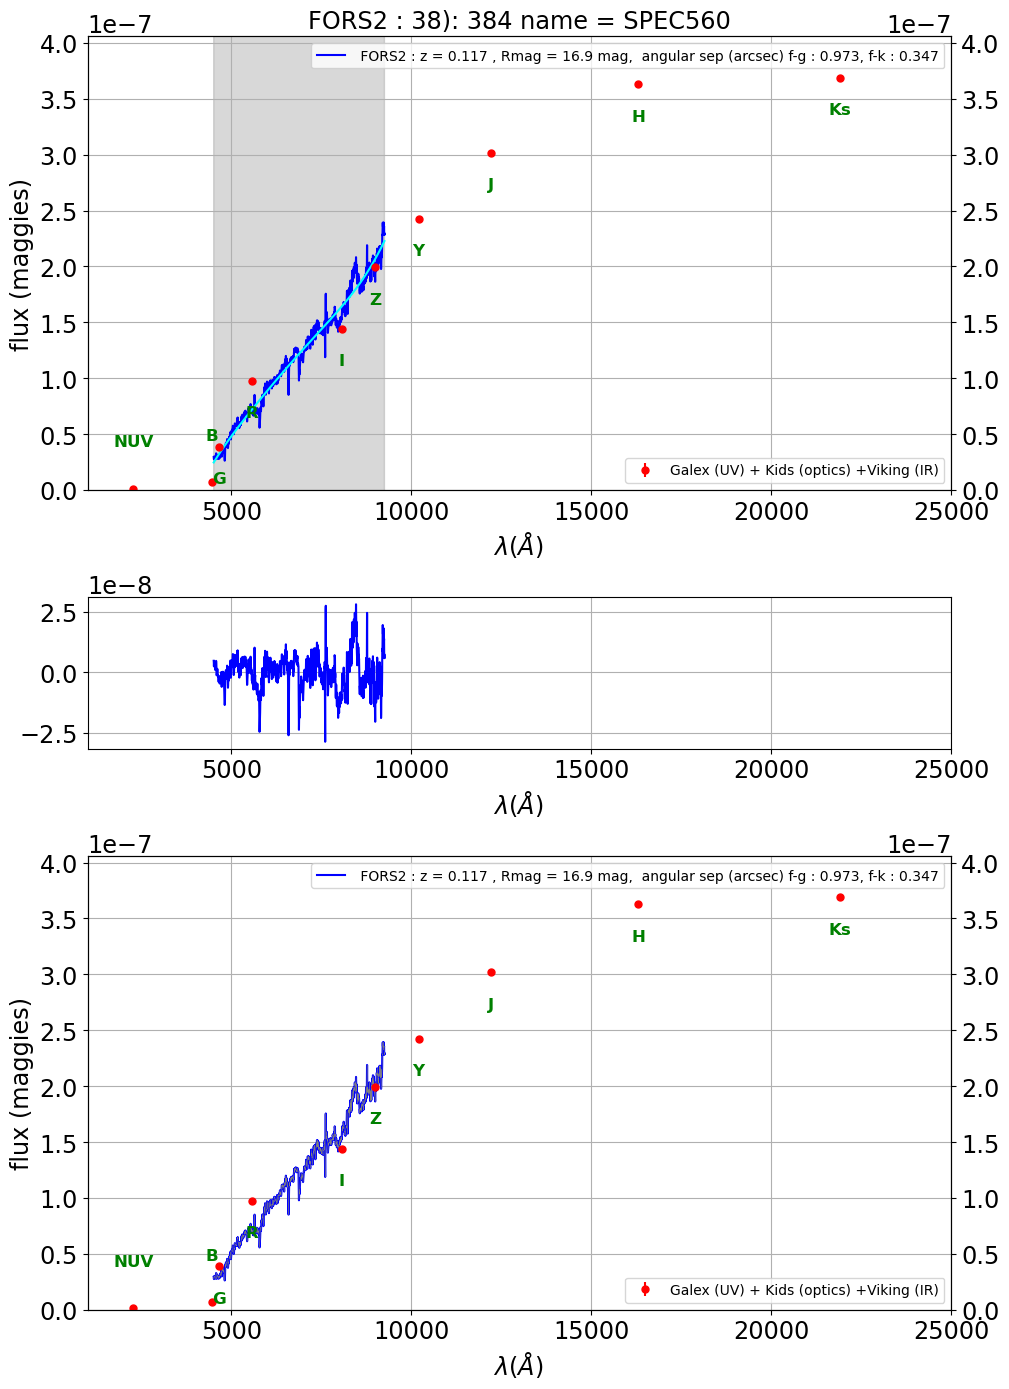

39  ==  SPEC563 563 386


In [39]:
# loop on rows
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for idx,row in df.iterrows():
    
    print(idx," == ",row["name"],row["num"],row["index0"])
    idx0 = row["index0"] # index for the spectrum
    specname  = row["name"]
    specnum = row["num"]
    if specnum < selected_spectrum_number:
        continue
    if specnum > selected_spectrum_number:
        break
    
    
    mags = [ row["fuv_mag"], row["nuv_mag"], row['MAG_GAAP_u'], row['MAG_GAAP_g'], row['MAG_GAAP_r'], row['MAG_GAAP_i'], row['MAG_GAAP_Z'], row['MAG_GAAP_Y'], 
            row['MAG_GAAP_J'], row['MAG_GAAP_H'],row['MAG_GAAP_Ks'] ]
    
    magserr = [ row["fuv_magerr"], row["nuv_magerr"], row['MAGERR_GAAP_u'], row['MAGERR_GAAP_g'], row['MAGERR_GAAP_r'], row['MAGERR_GAAP_i'], row['MAGERR_GAAP_Z'], row['MAGERR_GAAP_Y'], 
            row['MAGERR_GAAP_J'], row['MAGERR_GAAP_H'],row['MAGERR_GAAP_Ks'] ]
    
    mfluxes = [ 10**(-0.4*m) for m in mags ]
    mfluxeserr = []
    
    for f,em in zip(mfluxes,magserr):
        ferr = 0.4*np.log(10)*em*f
        mfluxeserr.append(ferr)
        
    mfluxes = np.array(mfluxes)
    mfluxeserr = np.array(mfluxeserr)
    
    fluxes =  [ row["fuv_flux"], row["nuv_flux"], row['FLUX_GAAP_u'], row['FLUX_GAAP_g'], row['FLUX_GAAP_r'], row['FLUX_GAAP_i'], row['FLUX_GAAP_Z'], row['FLUX_GAAP_Y'], 
            row['FLUX_GAAP_J'], row['FLUX_GAAP_H'],row['FLUX_GAAP_Ks'] ]
    
    fluxeserr =  [ row["fuv_fluxerr"], row["nuv_fluxerr"], row['FLUXERR_GAAP_u'], row['FLUXERR_GAAP_g'], row['FLUXERR_GAAP_r'], row['FLUXERR_GAAP_i'], row['FLUXERR_GAAP_Z'], row['FLUX_GAAP_Y'], 
            row['FLUXERR_GAAP_J'], row['FLUXERR_GAAP_H'],row['FLUXERR_GAAP_Ks'] ]
    
    ##############################################################
    # The top image
    ######################################
    fig = plt.figure(figsize=(10,14),tight_layout=True)
    gs = gridspec.GridSpec(3, 1,height_ratios=[3, 1, 3])
    
    
    #top image : original flux
    ax= fig.add_subplot(gs[0, 0])
    
    z = row["redshift"]
    asep_fg = row['asep_galex']
    rmag = row["Rmag"]
    asep_fk = row['asep_kids']
    
  
    the_lines = row['lines']
    print("the_lines = ",the_lines)
    all_elements  = the_lines.decode().split(",")
    
    
    the_label_data = f" FORS2 : z = {z:.3f} , Rmag = {rmag:.1f} mag,  angular sep (arcsec) f-g : {asep_fg:.3f}, f-k : {asep_fk:.3f}" 
    the_wl = all_df[idx0]["wl"].values
    the_fnu = all_df[idx0]["fnu"].values*10**(-0.4*mags[4])    
    ax.plot(the_wl,the_fnu,'b-',label=the_label_data)
     
    X = the_wl
    Y = the_fnu
    gp.fit(X[:, None], Y)
    xfit = np.linspace(X.min(),X.max())
    yfit, yfit_err = gp.predict(xfit[:, None], return_std=True)
    ax.plot(xfit, yfit, '-', color='cyan')
    ax.fill_between(xfit, yfit -  yfit_err, yfit +  yfit_err, color='gray', alpha=0.3)
     
    ax2 = ax.twinx()
    ax2.errorbar(WL,mfluxes,yerr=mfluxeserr,fmt='o',color="r",ecolor="r",ms=5,label='Galex (UV) + Kids (optics) +Viking (IR)')
    PlotFilterTag(ax2,mfluxes)
    #ax2.errorbar(WL, fluxes, yerr=fluxes, xerr=None, fmt='o', color="g",ecolor="g")
    ax2.legend(loc="lower right")
    
    ax.set_xlabel("$\lambda  (\AA)$ ")
    title_data = f"FORS2 : {idx}): {idx0} name = {specname}"
    ax.set_title(title_data)
    ax.set_ylabel("flux (maggies)")
    ax.legend(loc="upper right")
    ax.grid()
    
    the_max1 = np.max(the_fnu)
    goodmags = mfluxes[np.isfinite(mfluxes)]
    the_max2 = np.max(goodmags)
    the_max = 1.1*max(the_max1,the_max2)

    ax.set_ylim(0,the_max)
    ax2.set_ylim(0,the_max)

    ax.set_xlim(1000.,25000.)
    ##################
    # Middle image : Fit a gaussian process and compute the residuals
    ##################
    ax3 = fig.add_subplot(gs[1, 0])
    DeltaY,DeltaEY = Y - gp.predict(X[:, None], return_std=True)
    ax3.plot(X,DeltaY,'b')
    ax3.set_xlim(1000.,25000.)
    ax3.grid()
    ax3.set_xlabel("$\lambda  (\AA)$ ")
    
    background = np.sqrt(np.median(DeltaY**2))
    indexes_toremove = np.where(np.abs(DeltaY)> 8 * background)[0]
    
    for index in indexes_toremove:
        ax3.axvline(X[index],color='k')
    
    #########################    
    # Bottom image : resuting image after removing emission lines
    #########################
    
    ax4 = fig.add_subplot(gs[2, 0])
    
    Xclean = np.delete(X,indexes_toremove)
    Yclean  = np.delete(Y,indexes_toremove)
    
    ax4.plot(Xclean, Yclean,'b-',label=the_label_data)
    ax4.set_ylim(0,the_max)
    ax4.set_xlim(1000.,25000.)
    ax4.grid()
    ax4.set_xlabel("$\lambda  (\AA)$ ")
    
    ax5 = ax4.twinx()
    ax5.errorbar(WL,mfluxes,yerr=mfluxeserr,fmt='o',color="r",ecolor="r",ms=5,label='Galex (UV) + Kids (optics) +Viking (IR)')
    ax5.legend(loc="lower right")
    ax5.set_ylim(0,the_max)
    PlotFilterTag(ax5,mfluxes)
    
    ax4.set_ylabel("flux (maggies)")
    ax4.legend(loc="upper right")
    
    spectr = fors2.getspectrumcleanedemissionlines_fromgroup(specname,gp)

    the_wl = all_df[idx0]["wl"].values
    the_fnu = all_df[idx0]["fnu"].values*10**(-0.4*mags[4])
    
    ax5.plot(the_wl,the_fnu,color="grey",lw=0.25,label="original")

    
    plt.show()

In [40]:
z

0.11731

# Model of a galaxy

### Load SED templates

In [41]:

#ssp_data = load_ssp_templates(fn='tempdata_v2.h5')
ssp_data = load_ssp_templates(fn='../examples_dsps_diffstar_diffmah/tempdata.h5')

print(ssp_data._fields)

print('ssp_data : ssp_lgmet.shape = {}'.format(ssp_data.ssp_lgmet.shape))
print('ssp_data : ssp_lg_age_gyr.shape = {}'.format(ssp_data.ssp_lg_age_gyr.shape))
print('ssp_data : ssp_wave.shape = {}'.format(ssp_data.ssp_wave.shape))
print('ssp_data :ssp_flux.shape = {}'.format(ssp_data.ssp_flux.shape))

('ssp_lgmet', 'ssp_lg_age_gyr', 'ssp_wave', 'ssp_flux')
ssp_data : ssp_lgmet.shape = (12,)
ssp_data : ssp_lg_age_gyr.shape = (107,)
ssp_data : ssp_wave.shape = (5994,)
ssp_data :ssp_flux.shape = (12, 107, 5994)


### calculate age distribution

In [42]:
today_gyr = 13.8 
tarr = np.linspace(0.1, today_gyr, 100)

In [43]:
sfh_gal = sfh_singlegal(tarr, DEFAULT_MAH_PARAMS, DEFAULT_MS_PARAMS, DEFAULT_Q_PARAMS)

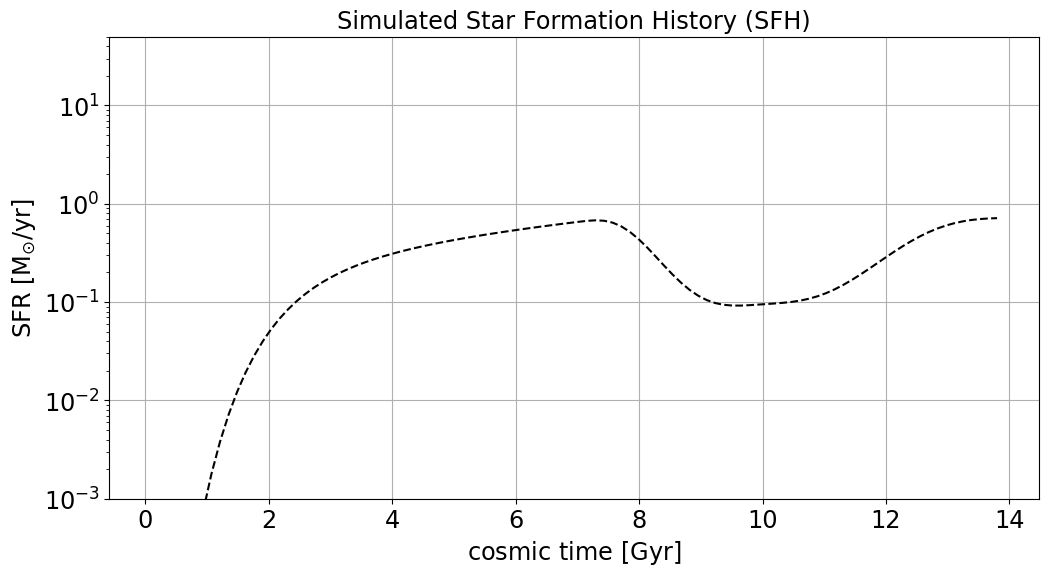

In [44]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(1e-3, 50)
yscale = ax.set_yscale('log')

__=ax.plot(tarr, sfh_gal, '--', color='k',label='sfh_gal')
ax.set_title("Simulated Star Formation History (SFH)")
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm SFR\ [M_{\odot}/yr]}$')
ax.grid()

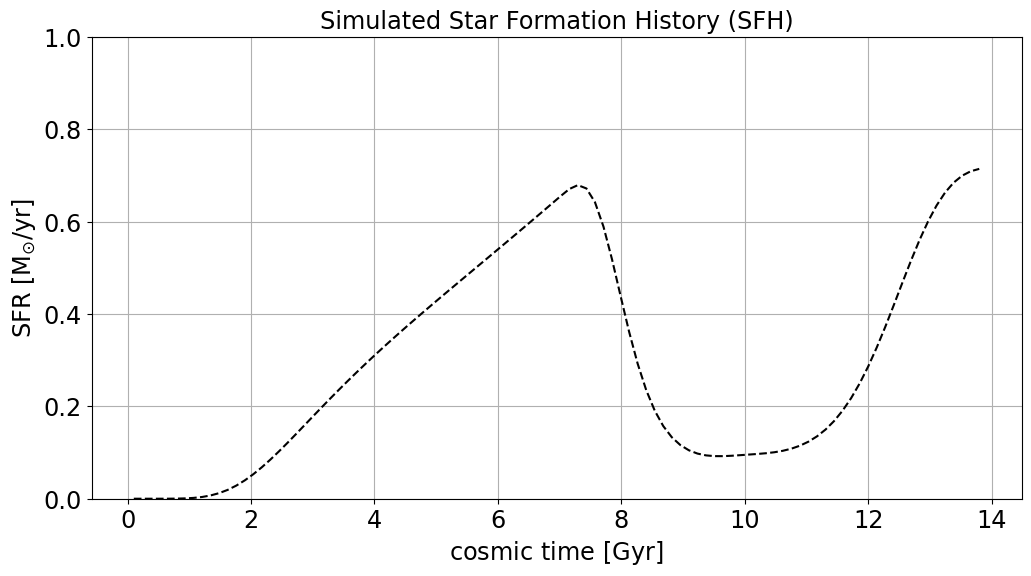

In [45]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 1)
#yscale = ax.set_yscale('log')

__=ax.plot(tarr, sfh_gal, '--', color='k',label='sfh_gal')
ax.set_title("Simulated Star Formation History (SFH)")
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm SFR\ [M_{\odot}/yr]}$')
ax.grid()

In [46]:
gal_t_table = tarr

In [47]:
z_obs = z
t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument

In [48]:
gal_sfr_table = sfh_gal
# metallicity
gal_lgmet = -2.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function


In [49]:
# calculate first SED with only one metallicity
print("gal_lgmet = ", gal_lgmet)

sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
    gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)

gal_lgmet =  -2.0


In [50]:
Av= 1.0
uv_bump_ampl = 3.0
plaw_slope = -0.25
wave_spec_micron = ssp_data.ssp_wave/10_000

In [51]:
k = sbl18_k_lambda(wave_spec_micron,uv_bump_ampl,plaw_slope)
dsps_flux_ratio = _frac_transmission_from_k_lambda(k,Av)

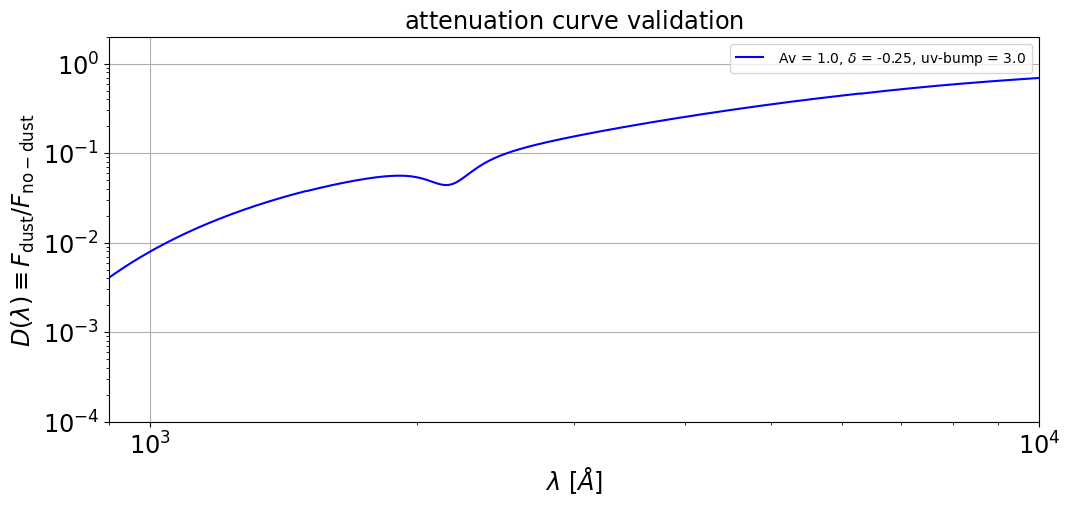

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
# fig.tight_layout(pad=3.0)

label_dust = f" Av = {Av}, $\delta$ = {plaw_slope}, uv-bump = {uv_bump_ampl}"
ax.plot(ssp_data.ssp_wave ,dsps_flux_ratio,'b-',label=label_dust)

xlim = ax.set_xlim(900, 1e4)
ylim = ax.set_ylim(1e-4, 2)
__=ax.loglog()

title = ax.set_title(r'${\rm attenuation\ curve\ validation}$')
xlabel = ax.set_xlabel(r'$\lambda\ [\AA]$')
ylabel= ax.set_ylabel(r'$D(\lambda)\equiv F_{\rm dust}/F_{\rm no-dust}$')
ax.legend()
ax.grid()

In [53]:
sed_attenuated = dsps_flux_ratio * sed_info.rest_sed

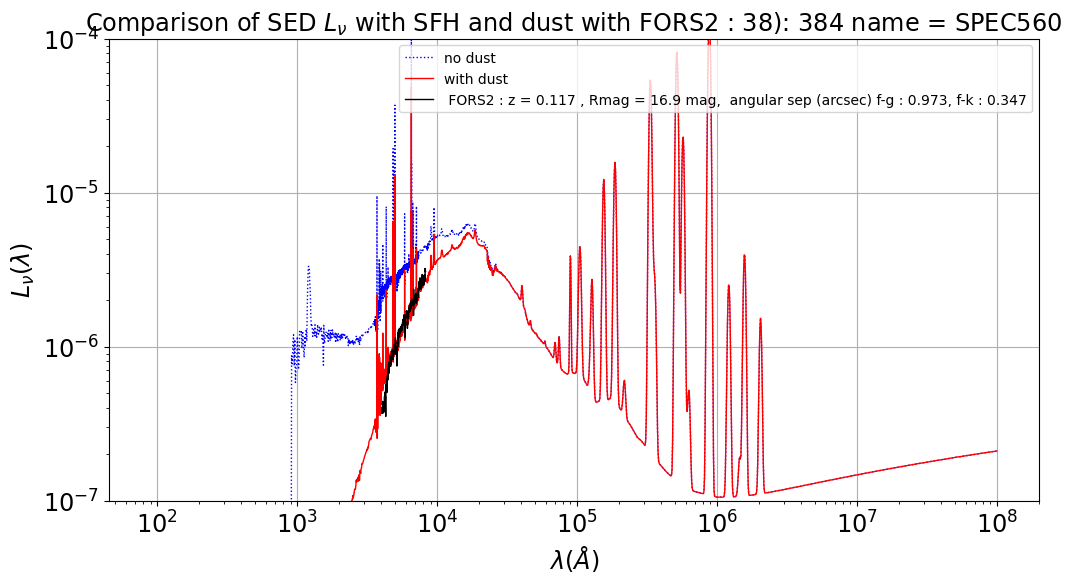

In [54]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(ssp_data.ssp_wave, sed_info.rest_sed,'b:',lw=1,label="no dust")
__=ax.plot(ssp_data.ssp_wave, sed_attenuated,'r-',lw=1,label="with dust")
__=ax.set_ylim(1e-7,1e-4)
ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\\nu(\lambda)$")




X = the_wl/(1+z_obs)
Y = the_fnu*(1+z)*dict_normalisation_factor[selected_spectrum_number]
 
ax.plot(X,Y,'k-',lw=1,label=the_label_data)
ax.legend()

title = "Comparison of SED $L_\\nu$ with SFH and dust with " + title_data
ax.set_title(title)
ax.grid()